# Question Answering

This notebook shows an example of using circular convolution binding to create a system that can bind semantic pointers and use them to answer simple questions.

In [28]:
%matplotlib widget
import nengo

import numpy as np
import matplotlib.pyplot as plt
from nengo.spa import Vocabulary

In [9]:
N_DIM = 20
N_NEURONS = 300
N_CONV = 70

In [10]:
rng = np.random.RandomState(0)
vocab = Vocabulary(N_DIM, rng=rng, max_similarity=0.1)
model = nengo.Network(label="Question Answering", seed=0)

In [11]:
# Getting semantic pointer values
CIRCLE = vocab.parse("CIRCLE").v
BLUE = vocab.parse("BLUE").v
RED = vocab.parse("RED").v
SQUARE = vocab.parse("SQUARE").v
ZERO = [0] * N_DIM

# Function for providing color input
def color_input(t):
    if (t // 0.5) % 2 == 0:
        return RED
    return BLUE

# Function for providing shape input
def shape_input(t):
    if (t // 0.5) % 2 == 0:
        return CIRCLE
    return SQUARE

# Function for providing the cue
def cue_input(t):
    sequence = [ZERO, CIRCLE, RED, ZERO, SQUARE, BLUE]
    idx = int((t // (1.0 / len(sequence))) % len(sequence))
    return sequence[idx]

In [15]:
with model:
    ens_shape = nengo.Ensemble(N_NEURONS, N_DIM, label="Shape")
    ens_color = nengo.Ensemble(N_NEURONS, N_DIM, label="Color")
    ens_object = nengo.Ensemble(N_NEURONS, N_DIM, label="Object")
    ens_cue = nengo.Ensemble(N_NEURONS, N_DIM, label="Cue")
    ens_answer = nengo.Ensemble(N_NEURONS, N_DIM, label="Answer")

    net_bind = nengo.networks.CircularConvolution(N_CONV, N_DIM, label="Bind")
    nengo.Connection(ens_shape, net_bind.A)
    nengo.Connection(ens_color, net_bind.B)
    nengo.Connection(net_bind.output, ens_object)

    net_unbind = nengo.networks.CircularConvolution(N_CONV, N_DIM, invert_a=True)
    nengo.Connection(ens_cue, net_unbind.A)
    nengo.Connection(ens_object, net_unbind.B)
    nengo.Connection(net_unbind.output, ens_answer)

    input_color = nengo.Node(output=color_input, size_out=N_DIM, label="Input Color")
    input_shape = nengo.Node(output=shape_input, size_out=N_DIM, label="Input Shape")
    input_cue = nengo.Node(output=cue_input, size_out=N_DIM, label="Input Cue")

    nengo.Connection(input_color, ens_color)
    nengo.Connection(input_shape, ens_shape)
    nengo.Connection(input_cue, ens_cue)

    p_answer = nengo.Probe(ens_answer, synapse=0.01)
    p_cue = nengo.Probe(ens_cue, synapse=0.01)
    p_shape = nengo.Probe(ens_shape, synapse=0.01)
    p_color = nengo.Probe(ens_color, synapse=0.01)

In [16]:
sim = nengo.Simulator(model)
with sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/tariq/miniconda3/envs/nengo-tutorials/lib/python3.13/site-packages/nengo/builder/optimizer.py:654: UserWarning: Skipping some optimization steps because SciPy is not installed. Installing SciPy may result in faster simulations.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [25]:
cue = {k : np.dot(sim.data[p_cue], v) for k, v in zip(vocab.keys, vocab.vectors)}
answer = {k : np.dot(sim.data[p_answer], v) for k, v in zip(vocab.keys, vocab.vectors)}
shape = {k : np.dot(sim.data[p_shape], v) for k, v in zip(vocab.keys, vocab.vectors)}
color = {k : np.dot(sim.data[p_color], v) for k, v in zip(vocab.keys, vocab.vectors)}

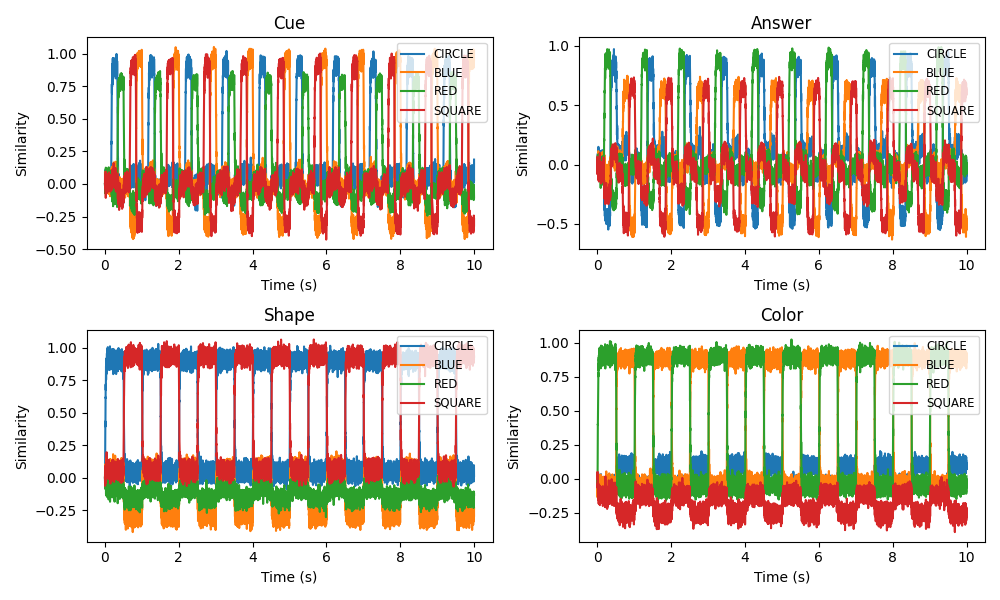

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

data = {"Cue": cue, "Answer": answer, "Shape": shape, "Color": color}

for ax, (title, d) in zip(axs.flatten(), data.items()):
    for k, v in d.items():
        ax.plot(sim.trange(), v, label=k)
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize="small")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Similarity")

plt.tight_layout()
plt.show()

The cue acts as a question. E.g when it is circle it is asking what color is the circle. When it is red it is asking what is the shape?
The results show that the answer is reliably generated as the most similar word in the vocab.

# Using SPA

In [32]:
import nengo.spa as spa

In [34]:
N_DIM = 32

In [41]:
rng = np.random.RandomState(0)
vocab = Vocabulary(N_DIM, rng=rng, max_similarity=0.1)
model = nengo.Network(label="Question Answering", seed=0)

In [42]:
CIRCLE = vocab.parse("CIRCLE")
BLUE = vocab.parse("BLUE")
RED = vocab.parse("RED")
SQUARE = vocab.parse("SQUARE")
ZERO = vocab.add("ZERO", [0] * N_DIM)

In [36]:
def color_input(t):
    if (t // 0.5) % 2 == 0:
        return "RED"
    return "BLUE"

def shape_input(t):
    if (t // 0.5) % 2 == 0:
        return "CIRCLE"
    return "SQUARE"

def cue_input(t):
    sequence = ["ZERO", "CIRCLE", "RED", "ZERO", "SQUARE", "BLUE"]
    idx = int((t // (1.0 / len(sequence))) % len(sequence))
    return sequence[idx]

In [43]:
model = spa.SPA(label="Question Answering SPA", vocabs=[vocab])
with model:
    model.Shape = spa.State(N_DIM, label="Shape")
    model.Color = spa.State(N_DIM, label="Color")
    model.Object = spa.State(N_DIM, label="Object")
    model.Cue = spa.State(N_DIM, label="Cue")
    model.Answer = spa.State(N_DIM, label="Answer")

    actions = spa.Actions(
        "Object = Shape * Color",
        "Answer = Object * ~Cue"
    )
    model.cortical = spa.Cortical(actions)
    model.input = spa.Input(
        Shape=shape_input,
        Color=color_input,
        Cue=cue_input
    )

    p_shape = nengo.Probe(model.Shape.output, synapse=0.01)
    p_color = nengo.Probe(model.Color.output, synapse=0.01)
    p_cue = nengo.Probe(model.Cue.output, synapse=0.01)
    p_answer = nengo.Probe(model.Answer.output, synapse=0.01)

In [44]:
sim = nengo.Simulator(model)
with sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [ ]:
cue = {k : np.dot(sim.data[p_cue], v) for k, v in zip(vocab.keys, vocab.vectors)}
answer = {k : np.dot(sim.data[p_answer], v) for k, v in zip(vocab.keys, vocab.vectors)}
shape = {k : np.dot(sim.data[p_shape], v) for k, v in zip(vocab.keys, vocab.vectors)}
color = {k : np.dot(sim.data[p_color], v) for k, v in zip(vocab.keys, vocab.vectors)}

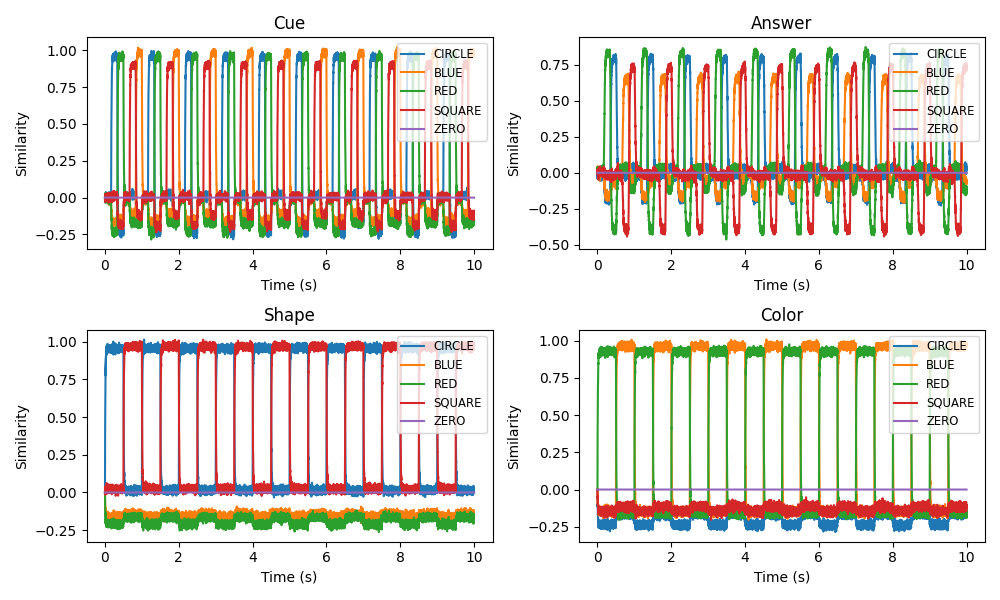

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

data = {"Cue": cue, "Answer": answer, "Shape": shape, "Color": color}

for ax, (title, d) in zip(axs.flatten(), data.items()):
    for k, v in d.items():
        ax.plot(sim.trange(), v, label=k)
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize="small")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Similarity")

plt.tight_layout()
plt.show()